Initialising

In [ ]:
import torch
import os
import string
import unicodedata
from io import open
import glob
import time
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

training_iter = 4
dir_name = f"training_iter_{training_iter}"
full_dir_path = os.path.join(".", "training", dir_name)

# Create the output directory if it doesn't exist
os.makedirs(full_dir_path, exist_ok=True)

# model hyper params
n_hidden = 256
n_epoch = 40
learning_rate = 0.15
n_batch_size = 108

Using device = cpu


Unicode to Ascii Cleaning function

In [29]:
# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

Go from ascii characters to tensor

In [31]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# print (f"The letter 'a' becomes {lineToTensor('a')}") #notice that the first position in the tensor = 1
# print (f"The name 'Ahn' becomes {lineToTensor('Ahn')}") #notice 'A' sets the 27th index to 1


Defining our model

In [32]:
class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

Retrieving all data from /data/names

In [33]:
alldata = NamesDataset("data/names")
# print(f"loaded {len(alldata)} items of data")
# print(f"example = {alldata[0]}")

split the data into train and test sets. Here we create a 80/20. For training and then validation.

In [34]:
train_set, test_set = torch.utils.data.random_split(alldata, [.80, .20], generator=torch.Generator(device=device).manual_seed(2024))

# print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")


Creating the network

In [35]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        _, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [53]:

rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(58, 256)
  (h2o): Linear(in_features=256, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


create label output

In [46]:
def label_from_output(output, output_labels):
    _, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

# input = lineToTensor('Albert')
# output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
# print(output)
# print(label_from_output(output, alldata.labels_uniq))

In [38]:
def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for _, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [ ]:
start = time.time()
all_losses = train(
    rnn,
    train_set,
    n_epoch=n_epoch,
    n_batch_size=n_batch_size,
    learning_rate=learning_rate,
    report_every=5
)
end = time.time()
print(f"training took {end-start}s")


training on data set with n = 16060


/var/folders/m0/v8ljs5kn4_b_sdgwg02jnv6c0000gn/T/ipykernel_68242/1608073774.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


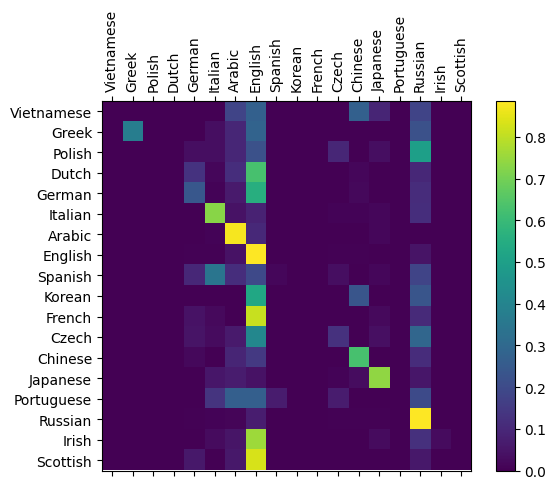

In [55]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (_, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            _, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.show()
    # sphinx_gallery_thumbnail_number = 2
    return fig
    


confusion = evaluate(rnn, test_set, classes=alldata.labels_uniq)


bright spots off the main axis that show which languages it guesses incorrectly.

rnn architecture:
CharRNN(
  (rnn): RNN(58, 256)
  (h2o): Linear(in_features=256, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

n_hidden = 256

n_epoch = 40

learning_rate = 0.01

train examples = 16060, validation examples = 4014



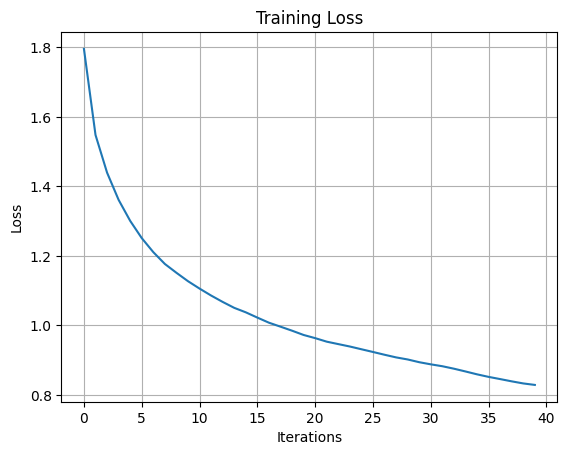

training took 561.1874389648438s



In [56]:
# save all training data 

# Save model info and hyper params
with open(f"{full_dir_path}/rnn_info_{training_iter}.txt", "w") as f:
    f.write(f"n_hidden = {n_hidden}\n")
    f.write(f"rnn architecture:\n{rnn}\n")
    f.write(f"n_epoch = {n_epoch}\n")
    f.write(f"learning_rate = {learning_rate}\n")
    f.write(f"n_batch_size = {n_batch_size}\n")
print(f"rnn architecture:\n{rnn}\n")
print(f"n_hidden = {n_hidden}\n")
print(f"n_epoch = {n_epoch}\n")
print(f"learning_rate = {learning_rate}\n")



# Save model info to a text file
with open(f"{full_dir_path}/training_validation_ratio_{training_iter}.txt", "w") as f:
    f.write(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}\n")

# plot losses
plt.figure()
plt.plot(all_losses)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig(f"{full_dir_path}/training_loss_entropy_{training_iter}.png")
plt.show()


# Save training time
with open(f"{full_dir_path}/training_time_{training_iter}.txt", "w") as f:
    f.write(f"training took {end-start}s")
print(f"training took {end-start}s\n")

# save confusion 
confusion.savefig(f"{full_dir_path}/confusion_matrix_{training_iter}.png")

